In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.model.mlm.pet_for_text_classification import train as train_model
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "PET"
dataset_name = "RAFT-ETHOS"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Loading dataset

In [4]:
dataset = load_dataset(
    "ethos",
    "binary" ,
    cache_dir= "/Data/pedro.silva"
)

In [52]:
train_dataset = dataset['train']

In [53]:
classes = np.unique(train_dataset['label'], return_counts=True)
classes

(array([0, 1]), array([565, 433]))

In [54]:
classes_names = ["normal", "hate"]

In [55]:
train_df_pandas = train_dataset.to_pandas()

In [64]:
mask = train_df_pandas['text'].apply(lambda x: len(x) < 450)
train_df_pandas= train_df_pandas[mask]

In [65]:
.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
        
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': [],
    }

    validation_data = {
        "label" : [],
        "text": [],
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = round(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
            
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## Few shot learning study - 50 shots

In [66]:
classes = np.unique(train_df_pandas['label'], return_counts=True)
train_validation, test_df = stratified_train_test_split(
    train_df_pandas,
    classes,
    train_size = 50
)

In [67]:
train, val  = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [68]:
val = pd.DataFrame(val).to_dict('list')
test = pd.DataFrame(test_df).sample(frac = 1).to_dict('list')

In [69]:
def pattern1(
    text: str, 
    tokenizer : AutoTokenizer
):
    return f"{text} is an example of a {tokenizer.mask_token} speech"

In [70]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")
class_names = ["normal", "hate"]

idx2class = {i : v for i,v in enumerate(class_names)}

class2idx = {v:i for i, v in enumerate(class_names)}


verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [71]:
verbalizer

{0: 3671, 1: 5223}

In [72]:

def preprocess(text: List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2class[labels[idx]]
        # text_ = text[idx]
        
        t= text[idx]

        processed_text.append(pattern1(t, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [73]:
train_text, train_labels = preprocess(train['text'], train['label'])
val_text, val_labels = preprocess(val['text'], val['label'])
test_text, test_labels = preprocess(test['text'],  test['label'])

In [74]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length = 512
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [75]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

0it [00:00, ?it/s]

30it [00:00, 88.81it/s]
20it [00:00, 104.32it/s]
928it [00:08, 105.83it/s]


In [76]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [77]:
_, class_counts = np.unique(
    train['label'],
    return_counts=True,
)

alpha = len(train['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val['label'],
    return_counts=True,
)
alpha_val = len(val['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test['label'],
    return_counts=True,
)
alpha_test = len(test['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([1.76470588, 2.30769231]),
 array([1.81818182, 2.22222222]),
 array([1.77099237, 2.2970297 ]))

In [78]:
from src.utils import FocalLoss

In [79]:
classes

(array([0, 1]), array([552, 426]))

In [80]:
len(val_text[-1].split(' '))

84

In [96]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train_model(
    train_dataloader,
    val_dataloader,
    num_classes = len(class_names),
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-4,
    lr=1e-5,
    evaluation_fn= binary_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=20
)

Epoch 19
f1-score : 0.2857142686843872
tensor([[8, 3],
        [7, 2]], device='cuda:0')


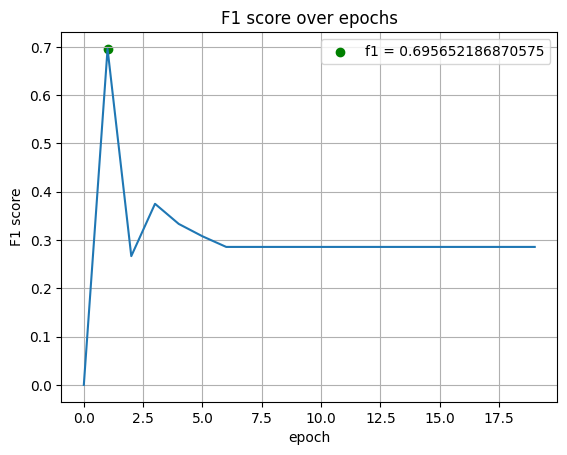

In [97]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-ETHOS - PET')

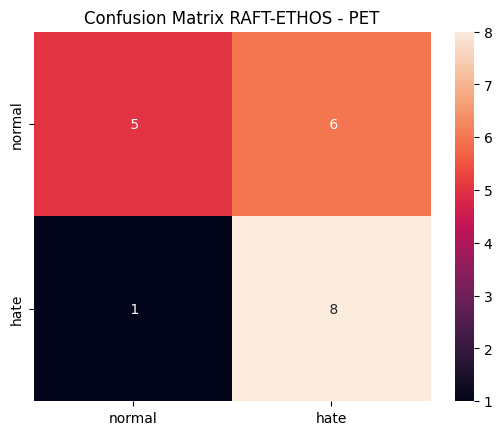

In [98]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [99]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [100]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = binary_f1_score(
        y_pred_test,
        y_true_test,
        # num_classes= len(classes[0])
    )

100%|██████████| 928/928 [00:08<00:00, 112.65it/s]


In [101]:
f1

tensor(0.6088, device='cuda:0')

Text(0.5, 1.0, 'Confusion Matrix RAFT-ETHOS - PET')

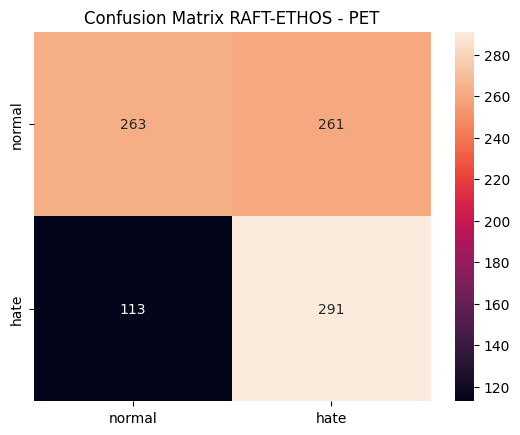

In [102]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(classes[0])
)

df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## General approach - 500 shots

In [103]:
classes = np.unique(train_df_pandas['label'], return_counts=True)
n_shots = 500
train_validation, test_df = stratified_train_test_split(
    train_df_pandas,
    classes,
    train_size = n_shots
)

In [104]:
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [105]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(frac = 1).to_dict('list')

In [106]:
verbalizer

{0: 3671, 1: 5223}

In [107]:
train_text, train_labels = preprocess(
    train_df['text'], 
    train_df['label']
)
val_text, val_labels = preprocess(
    val_df['text'], 
    val_df['label']
)
test_text, test_labels = preprocess(
    test_df['text'], 
    test_df['label']
)

In [108]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [109]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

300it [00:03, 97.71it/s] 
200it [00:02, 98.33it/s] 
478it [00:04, 101.46it/s]


In [110]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [111]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val_df['label'],
    return_counts=True,
)
alpha_val = len(val_df['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test_df['label'],
    return_counts=True,
)
alpha_test = len(test_df['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([1.77514793, 2.29007634]),
 array([1.7699115 , 2.29885057]),
 array([1.77037037, 2.29807692]))

In [112]:
from src.utils import FocalLoss

In [113]:
classes

(array([0, 1]), array([552, 426]))

In [114]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train_model(
    train_dataloader,
    val_dataloader,
    num_classes = len(class_names),
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-5,
    evaluation_fn= binary_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=10
)

Epoch 9
f1-score : 0.6369426250457764
tensor([[93, 20],
        [37, 50]], device='cuda:0')


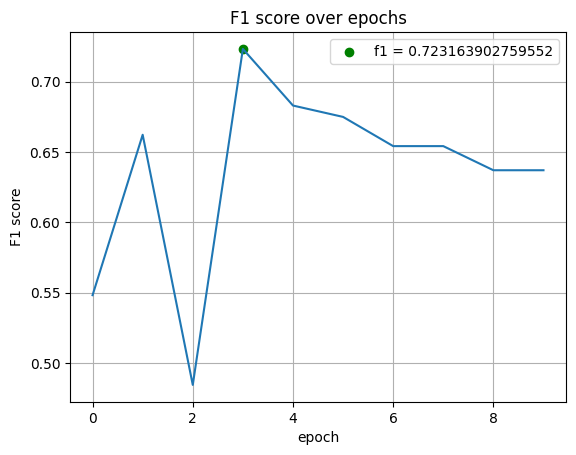

In [115]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-ETHOS - PET')

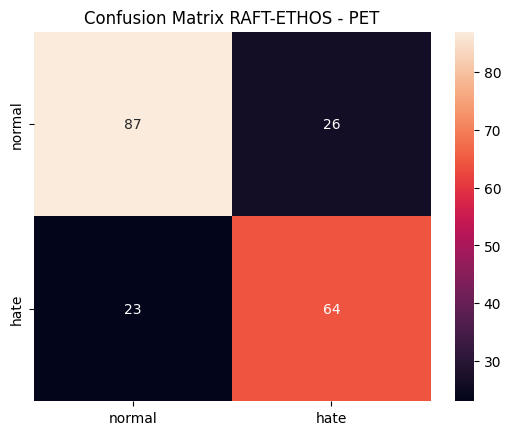

In [116]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [117]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [118]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = binary_f1_score(
        y_pred_test,
        y_true_test,
        # num_classes= len(classes[0])
    )

  0%|          | 0/478 [00:00<?, ?it/s]

100%|██████████| 478/478 [00:04<00:00, 111.28it/s]


In [119]:
f1

tensor(0.7014, device='cuda:0')